In [1]:
import pandas as pd 
import util
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
df = util.get_full_data_frame()
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [15]:
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train,sentences_test,y_train,y_test = train_test_split(sentences,y,test_size=0.25,random_state=1000)

print('Training set: {} '.format(len(sentences_train)))
print('Testing set: {} '.format(len(sentences_test)))

Training set: 750 
Testing set: 250 


In [16]:
# so in order to embed the words they first need to be tokenized (pre-processed)
tokenizer = Tokenizer(num_words=5000)
# this fills the dictionry of 5000 words with the words from the 750 yelp reviews
tokenizer.fit_on_texts(sentences_train)

# creates the vector representation of the sentences where each element is the index of that word in the dictionry
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  #reserves 0 index

print("Vocab Size: ", vocab_size)
print(X_train[1])
print(sentences_train[1])

Vocab Size:  1747
[740, 4, 46, 12, 20, 160, 10, 72, 35, 355, 232]
Sorry, I will not be getting food from here anytime soon :(


In [17]:
# Note: with this method, each vectorized review will be the length of the number of words in the review
# in order to use the vectors as feature vectors, they need to be the same size. So inorder to accomplish this,
# we have to padd the vectors to all be a sepcific length, the max size in our training set is 32. For good measure
# 100 elements will be suffice

maxlen = 100

X_train = pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test = pad_sequences(X_test,padding='post',maxlen=maxlen)

print(X_train[1])

[740   4  46  12  20 160  10  72  35 355 232   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [18]:
# okay so now we can get to the word embeddings. As a reminder, embedding just maps our words or sentences to a space
output_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=output_dim, 
                           input_length=maxlen))
# okay so here im adding a global pooling layer, which reduces the space to just 50 features while retaining information
#about the location of the word in the space
model.add(layers.GlobalMaxPooling1D())
# map to 10 dims
model.add(layers.Dense(10, activation='relu'))
# map to 1 dim which we use sigmoid to get out output
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 750 samples, validate on 250 samples
Epoch 1/20
750/750 [==============================] - 3s 4ms/step - loss: 0.6921 - acc: 0.5213 - val_loss: 0.6881 - val_acc: 0.6800
Epoch 2/20
750/750 [==============================] - 1s 1ms/step - loss: 0.6735 - acc: 0.8333 - val_loss: 0.6721 - val_acc: 0.6960
Epoch 3/20
750/750 [==============================] - 1s 1ms/step - loss: 0.6105 - acc: 0.8320 - val_loss: 0.6119 - val_acc: 0.7520
Epoch 4/20
750/750 [==============================] - 1s 1ms/step - loss: 0.4724 - acc: 0.9133 - val_loss: 0.5149 - val_acc: 0.7840
Epoch 5/20
750/750 [==============================] - 1s 1ms/step - loss: 0.2937 - acc: 0.9507 - val_loss: 0.4404 - val_acc: 0.8000
Epoch 6/20
750/750 [==============================] - 1s 1ms/step - loss: 0.1680 - acc: 0.9720 - val_loss: 0.4108 - val_acc: 0.8160
Epoch 7/20
750/750 [================

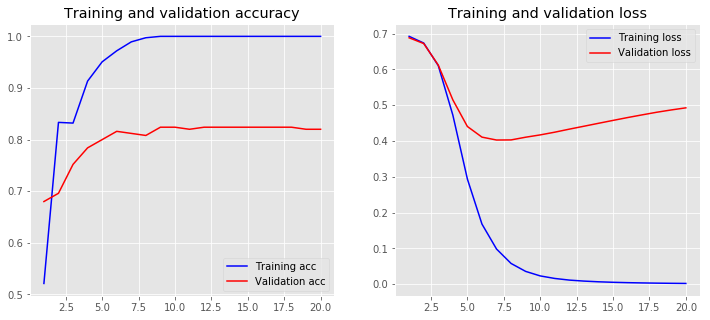

In [20]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
util.plot_history(history)

In [21]:
# so our model very clearly over fit to our training set. 
# however, 82% aint half bad, so lets see how well our model does on the other two data sets.

for source in df['source'].unique():
    
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values
    
    #preprocess X in the same way we did for our model
    X = tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(X,padding='post',maxlen=maxlen)
    
    loss, accuracy = model.evaluate(X, y, verbose=False)
    
    print('Accuracy for ',source,' data: ', accuracy)


Accuracy for  yelp  data:  0.955
Accuracy for  amazon  data:  0.762
Accuracy for  imdb  data:  0.7152406413924886


In [ ]:
# okay so not crazy hot here, but it works. The results are extremely similar to the nn_bow approach. That being said
# the emveddings did very little to help here.